# JATP Volume ratio parameter scan

Heatmaps for calculation of JATP Ratio between the mesophyll and bundle sheath cell types of the MaizeCore model under varying light uptake conditions iterated over severa; volume ratio values

### Imports

In [1]:
import pandas as pd
import sys
from cobra.io import read_sbml_model
from cobra import flux_analysis
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("..\Code")
from model_functions import *

## JATP Heatmap Analysis

### Reading and preparing "MaizeCore" model

In [2]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("..\Models\c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[M]_Maize_biomass_tx'

#Setting up Rubisco carboxylase/oxygenase (3:1) ratio in C4 model
const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[M]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

#Block Mesophyll and Bundle Sheath "External" Rubisco
set_bounds("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p", (0,0), c4_model)
set_bounds("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex", (0,0), c4_model)


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


### Parameterizing Flux Simulation

In [3]:
"""
Model simulation (autotrofic) with pFBA

Generation of a solution frame with resulting fluxes
"""

def simul_c4(light, nitrogen, carbon, light_ratio = 1, volume_ratio = 1):
     with c4_model:
        c4_model.objective = "[M]_Maize_biomass_tx" # Objective funtion established as Maize Biomass
        c4_model.solver = "glpk" # Setting up the solver

        # Adding constrains for model inputs
        medium = c4_model.medium
        medium["[M]_CO2_tx"] = carbon
        medium["[B]_Nitrate_tx"] = nitrogen
        c4_model.medium = medium

        # Implementation of the volume constrain occurs through constraining the exchange fluxes between the cell types in such a way that
        # [MB]_Metabolite_tx: 1 [M]_Metabolite_c <--> (1/Volume Ratio) [B]_Metabolite_c
        for reaction in c4_model.reactions:
            if reaction.id[0:4] == "[MB]":
                dict = {reaction.products[0] : -(1/volume_ratio)}
                reaction.subtract_metabolites(dict, combine=False)

        # Usage of the absolute values implies the consideration of the effect of the Volume Ratio on  light uptake into the bundle sheath  ([B]_Photon_tx * Volume Ratio)
        # previous to flux simulation and therefore its effect on Total Photon Uptake and on AB BS/M
        # This is achieved by considering this volume ratio in Total Light Uptake and AB BS/M by the model using the formulas below.
        set_bounds("[M]_Photon_tx", ((light/(light_ratio+1)), light/(light_ratio+1)), c4_model)
        set_bounds("[B]_Photon_tx", ((light-(light/(light_ratio+1)))/volume_ratio, (light-(light/(light_ratio+1)))/volume_ratio), c4_model)


        #Performing the pFBA simulation
        solution = flux_analysis.pfba(c4_model)
        solution_frame = solution.to_frame()

        return solution_frame


### Performing Flux simulations

In [4]:

# Providing list of light constrains for simulations
list_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,  1]
list_light = [50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

#### Function to generate the heatmap dataset

In [5]:
def heatmap(volume):

    Ratio_B = []
    Photon_Uptake = []
    AB = []
    JATP = []

    for r in list_ratio:
        for l in list_light:
            solution_frame = simul_c4(light=l, nitrogen=1000, light_ratio=r, volume_ratio=volume, carbon=40)
            B_atp = get_ATP_production("[B]", solution_frame, "]_ATP_", c4_model) + get_ATP_production("[B]",
                                                                                                    solution_frame,
                                                                                                    "]_aATP_", c4_model)
            M_atp = get_ATP_production("[M]", solution_frame, "]_ATP_", c4_model) + get_ATP_production("[M]",
                                                                                                    solution_frame,
                                                                                                    "]_aATP_", c4_model)
            res_photo_M = solution_frame.loc["[M]_Photon_tx"]["fluxes"]
            res_photo_B = solution_frame.loc["[B]_Photon_tx"]["fluxes"]

            AB.append(round((res_photo_B * volume) / res_photo_M, 1)) #Light Uptake by the BS is normalized by multiplication by the volume constraint
            JATP.append(round((B_atp * volume) / (M_atp), 1))  #ATP production by the BS is normalized by multiplication by the volume constraint
            Ratio_B.append(r)
            Photon_Uptake.append(round(res_photo_M + (res_photo_B * volume), 0))

    list_of_tuples = list(zip(Ratio_B, Photon_Uptake, AB, JATP))
    df_absolute = pd.DataFrame(list_of_tuples,
                    columns=["Ratio (BS/M)", "Light Uptake", "AB", "JATP"])
    return df_absolute

#### Implementation of $V_{Ratio} = 0.5$

In [6]:
#Set the volume constraint
volume = 0.5
df_absolute = heatmap(volume)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '50.0'),
  Text(1.5, 0, '100.0'),
  Text(2.5, 0, '150.0'),
  Text(3.5, 0, '200.0'),
  Text(4.5, 0, '300.0'),
  Text(5.5, 0, '400.0'),
  Text(6.5, 0, '500.0'),
  Text(7.5, 0, '600.0'),
  Text(8.5, 0, '700.0'),
  Text(9.5, 0, '800.0'),
  Text(10.5, 0, '900.0'),
  Text(11.5, 0, '1000.0')])

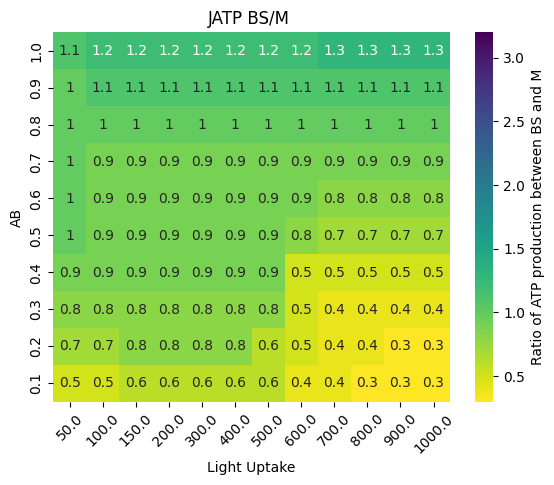

In [7]:
JATP_pivot = df_absolute.pivot(index="AB", columns="Light Uptake", values="JATP")
JATP_pivot.sort_index( ascending=False, inplace = True)
g = sns.heatmap(JATP_pivot, cmap = "viridis_r", cbar_kws={'label': 'Ratio of ATP production between BS and M'}, annot = True,vmin=0.3, vmax=3.2).set(title = "JATP BS/M ")
plt.xticks(rotation=45)

#### Implementation of $V_{Ratio} = 1$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '50.0'),
  Text(1.5, 0, '100.0'),
  Text(2.5, 0, '150.0'),
  Text(3.5, 0, '200.0'),
  Text(4.5, 0, '300.0'),
  Text(5.5, 0, '400.0'),
  Text(6.5, 0, '500.0'),
  Text(7.5, 0, '600.0'),
  Text(8.5, 0, '700.0'),
  Text(9.5, 0, '800.0'),
  Text(10.5, 0, '900.0'),
  Text(11.5, 0, '1000.0')])

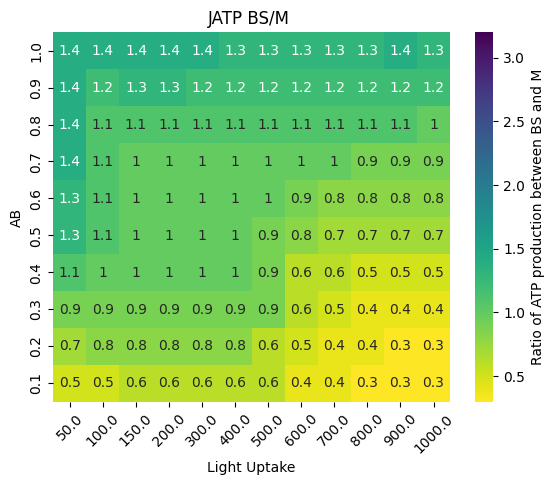

In [8]:
#Set the volume constraint
volume = 1

df_absolute = heatmap(volume)

JATP_pivot = df_absolute.pivot(index="AB", columns="Light Uptake", values="JATP")
JATP_pivot.sort_index(ascending=False, inplace=True)
g = sns.heatmap(JATP_pivot, cmap="viridis_r", cbar_kws={'label': 'Ratio of ATP production between BS and M'}, annot=True,vmin=0.3, vmax=3.2).set(title="JATP BS/M ")
plt.xticks(rotation=45)

#### Implementation of $V_{Ratio} = 2$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '50.0'),
  Text(1.5, 0, '100.0'),
  Text(2.5, 0, '150.0'),
  Text(3.5, 0, '200.0'),
  Text(4.5, 0, '300.0'),
  Text(5.5, 0, '400.0'),
  Text(6.5, 0, '500.0'),
  Text(7.5, 0, '600.0'),
  Text(8.5, 0, '700.0'),
  Text(9.5, 0, '800.0'),
  Text(10.5, 0, '900.0'),
  Text(11.5, 0, '1000.0')])

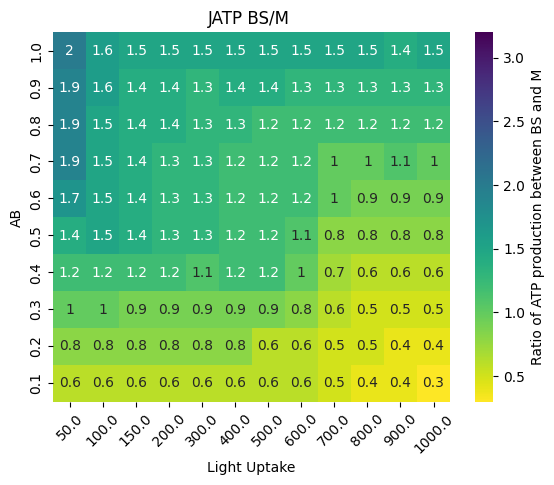

In [9]:
#Set the volume constraint
volume = 2
df_absolute = heatmap(volume)
JATP_pivot = df_absolute.pivot(index="AB", columns="Light Uptake", values="JATP")
JATP_pivot.sort_index(ascending=False, inplace=True)
g = sns.heatmap(JATP_pivot, cmap="viridis_r", cbar_kws={'label': 'Ratio of ATP production between BS and M'}, annot=True,vmin=0.3, vmax=3.2).set(title="JATP BS/M ")
plt.xticks(rotation=45)

#### Implementation of $V_{Ratio} = 3$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '50.0'),
  Text(1.5, 0, '100.0'),
  Text(2.5, 0, '150.0'),
  Text(3.5, 0, '200.0'),
  Text(4.5, 0, '300.0'),
  Text(5.5, 0, '400.0'),
  Text(6.5, 0, '500.0'),
  Text(7.5, 0, '600.0'),
  Text(8.5, 0, '700.0'),
  Text(9.5, 0, '800.0'),
  Text(10.5, 0, '900.0'),
  Text(11.5, 0, '1000.0')])

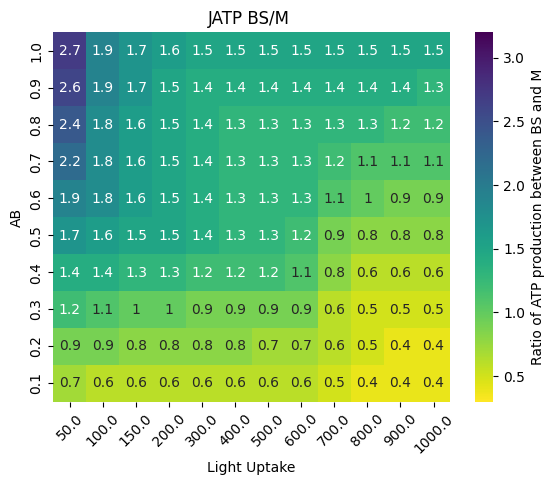

In [10]:
#Set the volume constraint
volume = 3

df_absolute = heatmap(volume)
JATP_pivot = df_absolute.pivot(index="AB", columns="Light Uptake", values="JATP")
JATP_pivot.sort_index(ascending=False, inplace=True)
g = sns.heatmap(JATP_pivot, cmap="viridis_r", cbar_kws={'label': 'Ratio of ATP production between BS and M'}, annot=True,vmin=0.3, vmax=3.2).set(title="JATP BS/M ")
plt.xticks(rotation=45)

#### Implementation of $V_{Ratio} = 4$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '50.0'),
  Text(1.5, 0, '100.0'),
  Text(2.5, 0, '150.0'),
  Text(3.5, 0, '200.0'),
  Text(4.5, 0, '300.0'),
  Text(5.5, 0, '400.0'),
  Text(6.5, 0, '500.0'),
  Text(7.5, 0, '600.0'),
  Text(8.5, 0, '700.0'),
  Text(9.5, 0, '800.0'),
  Text(10.5, 0, '900.0'),
  Text(11.5, 0, '1000.0')])

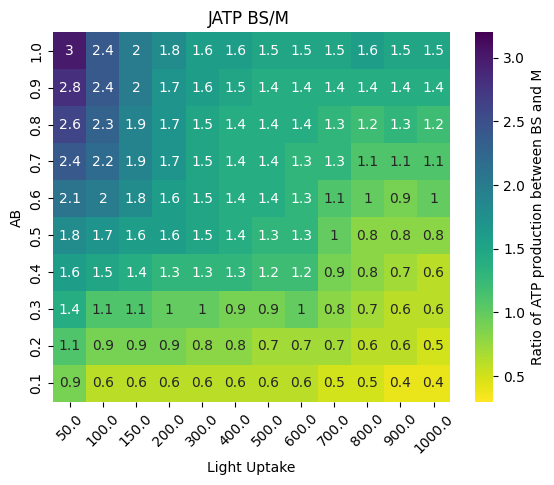

In [11]:
#Set the volume constraint
volume = 4

df_absolute = heatmap(volume)

JATP_pivot = df_absolute.pivot(index="AB", columns="Light Uptake", values="JATP")
JATP_pivot.sort_index(ascending=False, inplace=True)
g = sns.heatmap(JATP_pivot, cmap="viridis_r", cbar_kws={'label': 'Ratio of ATP production between BS and M'}, annot=True,vmin=0.3, vmax=3.2).set(title="JATP BS/M ")
plt.xticks(rotation=45)

#### Implementation of $V_{Ratio} = 5$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '50.0'),
  Text(1.5, 0, '100.0'),
  Text(2.5, 0, '150.0'),
  Text(3.5, 0, '200.0'),
  Text(4.5, 0, '300.0'),
  Text(5.5, 0, '400.0'),
  Text(6.5, 0, '500.0'),
  Text(7.5, 0, '600.0'),
  Text(8.5, 0, '700.0'),
  Text(9.5, 0, '800.0'),
  Text(10.5, 0, '900.0'),
  Text(11.5, 0, '1000.0')])

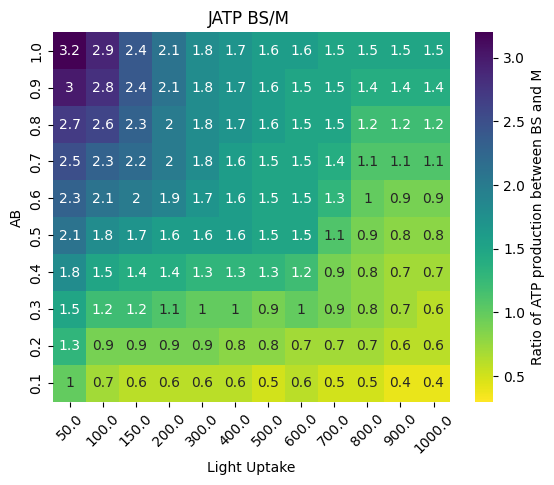

In [12]:
#Set the volume constraint
volume = 5

df_absolute = heatmap(volume)

JATP_pivot = df_absolute.pivot(index="AB", columns="Light Uptake", values="JATP")
JATP_pivot.sort_index(ascending=False, inplace=True)
g = sns.heatmap(JATP_pivot, cmap="viridis_r", cbar_kws={'label': 'Ratio of ATP production between BS and M'}, annot=True, vmin=0.3, vmax=3.2).set(title="JATP BS/M ")
plt.xticks(rotation=45)